<a href="https://colab.research.google.com/github/datascisteven/greenflash_llm_project/blob/main/Greenflash_Toxicity_Multi_Class_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authentication and Importing Necessary Libraries



# Authentication and Importing Packages

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# prompt: authenticate with hugging face
from huggingface_hub import login

login()

In [3]:
!pip install -q datasets transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.7 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler,
    random_split,
)
from transformers import (
    BertTokenizer,
    BertModel,
    AdamW,
    get_linear_schedule_with_warmup,
)
import time
import datetime
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    precision_recall_curve,
    auc
)

import re
import warnings
warnings.filterwarnings("ignore")

from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 200)
# pd.set_option('display.max_colwidth', None)

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

# Importing Dataset

**Dataset:**  [Jigsaw Unintended Bias in Toxicity Classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data)


- Comments labeled as having ```'toxicity'``` = 1 are defined as very bad, unpleasant, or harmful, each of which have one of the following additional labels:
    - ```'obscene'```: (of the portrayal or description of sexual matters) offensive or disgusting by accepted standards of morality and decency
    - ```'sexual_explicit'```
    - ```'insult'```: speak to or treat with disrespect or scornful abuse
    - ```'threat'```: a statement of an intention to inflict pain, injury, damage, or other hostile action on someone in retribution for something done or not done
    - ```'identity_attack'```: hatred, hostility, or violence towards members of a race, ethnicity, nation, religion, gender, gender identity, sexual orientation or any other designated sector of society1:
        - ```'gender'```: includes attacks labeled under ```male``` and ```female```
        - ```'sexual_orientation'```: includes attacks labeled under ```heterosexual```, ```homosexual_gay_or_lesbian```, ```bisexual```, ```transgender```, ```other_gender```, and ```other_sexual_orientation```
        - ```'religion'```: includes attacks under ```jewish```, ```muslim```, ```athiest```, ```hindu```, ```christian```, ```buddhist```, and ```other_religion```
        - ```'ability'```: includes attacks under ```physical_disability, Intellectual or Learning Disability, Psychiatric or Mental Illness, and Other Disability
        - ```'race'```: includes attacks labeled under White, Black, Latino, Asian, and Other Race or Ethnicity


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Projects/Greenflash/Toxicity/jigsaw_train_revised.csv', index_col=0)
dataset = dataset.drop(columns=['severe_toxicity'])
dataset = dataset[['id', 'comment_text', 'toxicity', 'obscene', 'sexual_explicit', 'insult', 'threat', 'identity_attack', 'race', 'gender', 'sexual_orientation', 'religion', 'ability']]
dataset.head()

,id,comment_text,toxicity,obscene,sexual_explicit,insult,threat,identity_attack,race,gender,sexual_orientation,religion,ability
0,1083994,He got his money... now he lies in wait till a...,0,0,0,0,0,0,0,0,0,0,0
1,650904,Mad dog will surely put the liberals in mental...,1,0,0,1,0,0,0,0,0,0,0
2,5902188,And Trump continues his lifelong cowardice by ...,1,0,0,1,0,0,0,0,0,0,0
4,5410943,Tucker and Paul are both total bad ass mofo's.,1,0,0,0,0,0,0,0,0,0,0
5,6290444,"Cry me a river, why don't you.\nDrinking, drug...",0,0,0,0,0,0,0,0,0,0,0


In [ ]:
dataset[['toxicity', 'obscene', 'sexual_explicit', 'insult', 'threat', 'identity_attack', 'race', 'gender', 'sexual_orientation', 'religion', 'ability']].apply(lambda x: x.value_counts()).T

,0,1
toxicity,1698374,106438
obscene,1797164,7648
sexual_explicit,1801693,3119
insult,1724925,79887
threat,1802019,2793
identity_attack,1797179,7633
race,1768565,36247
gender,1730699,74113
sexual_orientation,1792249,12563
religion,1747018,57794


In [ ]:
len(dataset)

1804812

In [ ]:
dataset.toxicity.value_counts()

,count
toxicity,
0,1698374
1,106438


In [ ]:
non_toxic = dataset.loc[dataset.toxicity==0]
toxic = dataset.loc[dataset.toxicity==1]

non_toxic = non_toxic.sample(n=len(toxic), random_state=42)

dataset = pd.concat([non_toxic, toxic])
dataset.toxicity.value_counts()

,count
toxicity,
0,106438
1,106438


In [ ]:
value_counts = dataset[['toxicity', 'obscene', 'sexual_explicit', 'insult', 'threat', 'identity_attack', 'race', 'gender', 'sexual_orientation', 'religion', 'ability']].apply(lambda x: x.value_counts()).T
value_counts['percentage'] = round(value_counts[1] / ((value_counts[0] + value_counts[1])) * 100, 2)
value_counts

,0,1,percentage
toxicity,106438,106438,50.00
obscene,205377,7499,3.52
sexual_explicit,210084,2792,1.31
insult,134658,78218,36.74
threat,210162,2714,1.27
identity_attack,205737,7139,3.35
race,204169,8707,4.09
gender,201222,11654,5.47
sexual_orientation,209991,2885,1.36
religion,204405,8471,3.98


In [ ]:
# Filter rows where the values in 'mixed_column' are not strings
non_string_rows = dataset[~dataset['comment_text'].apply(lambda x: isinstance(x, str))]

print(non_string_rows)

Empty DataFrame
Columns: [id, comment_text, toxicity, obscene, sexual_explicit, insult, threat, identity_attack, ia_race, ia_gender, ia_sexual_orientation, ia_religion, ia_ability]
Index: []


# Preparing Environment

In [5]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
    print("Using GPU: ", torch.cuda.current_device())
else:
    device = torch.device("cpu")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Using GPU:  0


# Preparing Dataset

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def get_dataset(df, tokenizer, mode="train"):
    sentences, labels = df["comment_text"], df.iloc[:, 2:].to_numpy()
    max_length = 300
    in_T = []
    in_T_attn_masks = []
    for sentence in sentences:
        enc_sent_dict = tokenizer.encode_plus(
            sentence[:300],
            max_length=max_length,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt",
        )
        in_T.append(enc_sent_dict["input_ids"])
        in_T_attn_masks.append(enc_sent_dict["attention_mask"])

    in_T = torch.cat(in_T, dim=0)
    in_T_attn_masks = torch.cat(in_T_attn_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.float32)
    print("Text Input: ", in_T.shape)
    print("Text Input Attention: ", in_T_attn_masks.shape)
    print("Labels: ", labels.shape)

    dataset = TensorDataset(in_T, in_T_attn_masks, labels)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset


train_dataset, val_dataset = get_dataset(
    dataset, tokenizer=tokenizer, mode="train"
)

batch_size = 8
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset)
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset)
)

print("Data Ready!!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Text Input:  torch.Size([1804812, 300])
Text Input Attention:  torch.Size([1804812, 300])
Labels:  torch.Size([1804812, 11])
Data Ready!!


# Preparing Model

- Why BERT?
    - Bidirectional Encoder Representations from Transformers serves two important roles in the scope of LLM's: q1111ZQ

- Class Definition and Initialization
    - This class defines a model that usess a pre-trained BERT model that I continually saw used through several models.
    - BERT's hidden size is always 768, which is why the input dimension of the first feedforward layer is 768.
    - Using Dropout is to prevent overfitting and improve generalization of the model.
    - The final layer outputs the logits for each of the labels, which are converted into probabilities using the sigmoid function.  The output size corresponds to the number of labels in our problem.

- Forward Pass Method
    - Switch to Max Pooling from Mean Pooling in effort to reduce the number of FN's

- Custom WeightedBCELoss Class Definition
    - goal is to reduce false negatives by giving more weight to positive sampels during training
    - encourages model to predict positive labels more frequently when unsure

In [7]:
class MultiTaskClassifier(nn.Module):
    def __init__(self, hidden_dim, num_labels):
        super(MultiTaskClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_labels = num_labels

        self.bertmodel = BertModel.from_pretrained("bert-base-uncased")
        self.ffn1 = nn.Linear(768, hidden_dim)
        self.dp1 = nn.Dropout(p=0.3)
        self.ffn2 = nn.Linear(hidden_dim, num_labels)

    def forward(self, in_T, in_T_attn_masks):
        hidden_states = self.bertmodel(in_T, in_T_attn_masks)[0]
        x, _ = torch.max(hidden_states, dim=1)
        x = F.relu(self.ffn1(x))
        x = self.dp1(x)
        x = torch.sigmoid(self.ffn2(x))
        return x

class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight

    def forward(self, predictions, targets):
        loss = - (self.pos_weight * targets * torch.log(predictions) + (1 - targets) * torch.log(1 - predictions))
        return loss.mean()


model = MultiTaskClassifier(100, 11).to(device)
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

pos_weight = 2.0
criterion = WeightedBCELoss(pos_weight=pos_weight)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Training and Validation



In [ ]:
len(train_dataloader)

21288

In [ ]:
classes = ['toxic',
            'obscene',
            'sexually explicit',
            'insult',
            'threat',
            'identity attack',
            'IA: race and ethnicity',
            'IA: gender',
            'IA: sexual orientation and gender identity',
            'IA: religion',
            'IA: disability']

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

training_stats = []
total_t0 = time.time()

best_val_loss = 1e8

true_labels = torch.cat([batch[2] for batch in val_dataloader]).numpy()

for epoch in range(0, epochs):

    print(f"\n======== Epoch {epoch + 1} / {epochs} ========")
    print("Training...")

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f" Batch {step:>5,}  of  {len(train_dataloader):>5,}. Elapsed: {elapsed}. Loss: {total_train_loss / step:.5f}")

        b_in_T = batch[0].to(device)
        b_in_T_attn_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        logits = model(b_in_T, b_in_T_attn_masks)
        loss = criterion(logits, b_labels)

        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print(f"\n  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")

    print("\nRunning Validation...")

    t0 = time.time()
    model.eval()

    total_eval_loss = 0
    pred_probabilities = np.empty((0, 11))

    for batch in val_dataloader:
        b_in_T = batch[0].to(device)
        b_in_T_attn_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            logits = model(b_in_T, b_in_T_attn_masks)
            loss = criterion(logits, b_labels)

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        pred_probabilities = np.concatenate((pred_probabilities, logits), axis=0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    validation_time = format_time(time.time() - t0)

    pred_labels = np.array(
        [[int(x >= 0.25) for x in pred_probabilities[:, i]] for i in range(11)]
    ).transpose()

    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

    for i in range(11):

        true_class_labels = true_labels[:, i]
        pred_class_probs = pred_probabilities[:, i]

        try:
            roc_auc = roc_auc_score(true_class_labels, pred_class_probs)
        except ValueError:
            roc_auc = float('nan')

        precision, recall, _ = precision_recall_curve(true_class_labels, pred_class_probs)
        pr_auc = auc(recall, precision)


        print(f"Class {i + 1}: ")
        print(f"    Class {i + 1} ROC AUC: {roc_auc:.2f}")
        print(f"    Class {i + 1} PR AUC: {pr_auc:.2f}")
        print(f"    Class {i + 1} Accuracy: {accuracy_score(true_labels[:, i], pred_labels[:, i]):.2f}")
        print(f"    Class {i + 1} Macro F1-score: {f1_score(true_labels[:, i], pred_labels[:, i], average='macro'):.2f}")
        print(f"    Class {i + 1} Weighted F1-score: {f1_score(true_labels[:, i], pred_labels[:, i], average='weighted'):.2f}")
        print(f"    Class {i + 1} Precision: {precision_score(true_labels[:, i], pred_labels[:, i]):.2f}")
        print(f"    Class {i + 1} Recall: {recall_score(true_labels[:, i], pred_labels[:, i]):.2f}")


    training_stats.append(
        {
            "epoch": epoch + 1,
            "training_loss": avg_train_loss,
            "avg_val_loss": avg_val_loss,
            "avg_val_accuracy": np.mean([accuracy_score(true_labels[:, i], pred_labels[:, i]) for i in range(11)]),
            "avg_val_macro_f1": np.mean([f1_score(true_labels[:, i], pred_labels[:, i], average="macro") for i in range(11)]),
            "avg_val_weighted_f1": np.mean([f1_score(true_labels[:, i], pred_labels[:, i], average="weighted") for i in range(11)]),
            "avy_val_roc_auc": np.nanmean([roc_auc_score(true_labels[:, i], pred_probabilities[:, i]) if len(np.unique(true_labels[:, i])) > 1 else float('nan') for i in range(11)]),
            "avg_val_pr_auc": np.mean([auc(precision_recall_curve(true_labels[:, i], pred_probabilities[:, i])[1], precision_recall_curve(true_labels[:, i], pred_probabilities[:, i])[0]) for i in range(11)]),
            "training_time": training_time,
            "val_time": validation_time,
            "val_accuracy_class_1": accuracy_score(true_labels[:, 0], pred_labels[:, 0]),
            "val_f1_class_1": f1_score(true_labels[:, 0], pred_labels[:, 0]),
            "val_precision_class_1": precision_score(true_labels[:, 0], pred_labels[:, 0]),
            "val_recall_class_1": recall_score(true_labels[:, 0], pred_labels[:, 0]),
            "val_roc_auc_class_1": roc_auc_score(true_labels[:, 0], pred_probabilities[:, 0]),
            "val_pr_auc_class_1": auc(precision_recall_curve(true_labels[:, 0], pred_probabilities[:, 0])[1], precision_recall_curve(true_labels[:, 0], pred_probabilities[:, 0])[0]),
            "val_accuracy_class_2": accuracy_score(true_labels[:, 1], pred_labels[:, 1]),
            "val_f1_class_2": f1_score(true_labels[:, 1], pred_labels[:, 1]),
            "val_precision_class_2": precision_score(true_labels[:, 1], pred_labels[:, 1]),
            "val_recall_class_2": recall_score(true_labels[:, 1], pred_labels[:, 1]),
            "val_roc_auc_class_2": roc_auc_score(true_labels[:, 1], pred_probabilities[:, 1]),
            "val_pr_auc_class_2": auc(precision_recall_curve(true_labels[:, 1], pred_probabilities[:, 1])[1], precision_recall_curve(true_labels[:, 1], pred_probabilities[:, 1])[0]),
            "val_accuracy_class_3": accuracy_score(true_labels[:, 2], pred_labels[:, 2]),
            "val_f1_class_3": f1_score(true_labels[:, 2], pred_labels[:, 2]),
            "val_precision_class_3": precision_score(true_labels[:, 2], pred_labels[:, 2]),
            "val_recall_class_3": recall_score(true_labels[:, 2], pred_labels[:, 2]),
            "val_roc_auc_class_3": roc_auc_score(true_labels[:, 2], pred_probabilities[:, 2]),
            "val_pr_auc_class_3": auc(precision_recall_curve(true_labels[:, 2], pred_probabilities[:, 2])[1], precision_recall_curve(true_labels[:, 2], pred_probabilities[:, 2])[0]),
            "val_accuracy_class_4": accuracy_score(true_labels[:, 3], pred_labels[:, 3]),
            "val_f1_class_4": f1_score(true_labels[:, 3], pred_labels[:, 3]),
            "val_precision_class_4": precision_score(true_labels[:, 3], pred_labels[:, 3]),
            "val_recall_class_4": recall_score(true_labels[:, 3], pred_labels[:, 3]),
            "val_roc_auc_class_4": roc_auc_score(true_labels[:, 3], pred_probabilities[:, 3]),
            "val_pr_auc_class_4": auc(precision_recall_curve(true_labels[:, 3], pred_probabilities[:, 3])[1], precision_recall_curve(true_labels[:, 3], pred_probabilities[:, 3])[0]),
            "val_accuracy_class_5": accuracy_score(true_labels[:, 4], pred_labels[:, 4]),
            "val_f1_class_5": f1_score(true_labels[:, 4], pred_labels[:, 4]),
            "val_precision_class_5": precision_score(true_labels[:, 4], pred_labels[:, 4]),
            "val_recall_class_5": recall_score(true_labels[:, 4], pred_labels[:, 4]),
            "val_roc_auc_class_5": roc_auc_score(true_labels[:, 4], pred_probabilities[:, 4]),
            "val_pr_auc_class_5": auc(precision_recall_curve(true_labels[:, 4], pred_probabilities[:, 4])[1], precision_recall_curve(true_labels[:, 4], pred_probabilities[:, 4])[0]),
            "val_accuracy_class_6": accuracy_score(true_labels[:, 5], pred_labels[:, 5]),
            "val_f1_class_6": f1_score(true_labels[:, 5], pred_labels[:, 5]),
            "val_precision_class_6": precision_score(true_labels[:, 5], pred_labels[:, 5]),
            "val_recall_class_6": recall_score(true_labels[:, 5], pred_labels[:, 5]),
            "val_roc_auc_class_6": roc_auc_score(true_labels[:, 5], pred_probabilities[:, 5]),
            "val_pr_auc_class_6": auc(precision_recall_curve(true_labels[:, 5], pred_probabilities[:, 5])[1], precision_recall_curve(true_labels[:, 5], pred_probabilities[:, 5])[0]),
            "val_accuracy_class_7": accuracy_score(true_labels[:, 6], pred_labels[:, 6]),
            "val_f1_class_7": f1_score(true_labels[:, 6], pred_labels[:, 6]),
            "val_precision_class_7": precision_score(true_labels[:, 6], pred_labels[:, 6]),
            "val_recall_class_7": recall_score(true_labels[:, 6], pred_labels[:, 6]),
            "val_roc_auc_class_7": roc_auc_score(true_labels[:, 6], pred_probabilities[:, 6]),
            "val_pr_auc_class_7": auc(precision_recall_curve(true_labels[:, 6], pred_probabilities[:, 6])[1], precision_recall_curve(true_labels[:, 6], pred_probabilities[:, 6])[0]),
            "val_accuracy_class_8": accuracy_score(true_labels[:, 7], pred_labels[:, 7]),
            "val_f1_class_8": f1_score(true_labels[:, 7], pred_labels[:, 7]),
            "val_precision_class_8": precision_score(true_labels[:, 7], pred_labels[:, 7]),
            "val_recall_class_8": recall_score(true_labels[:, 7], pred_labels[:, 7]),
            "val_roc_auc_class_8": roc_auc_score(true_labels[:, 7], pred_probabilities[:, 7]),
            "val_pr_auc_class_8": auc(precision_recall_curve(true_labels[:, 7], pred_probabilities[:, 7])[1], precision_recall_curve(true_labels[:, 7], pred_probabilities[:, 7])[0]),
            "val_accuracy_class_9": accuracy_score(true_labels[:, 8], pred_labels[:, 8]),
            "val_f1_class_9": f1_score(true_labels[:, 8], pred_labels[:, 8]),
            "val_precision_class_9": precision_score(true_labels[:, 8], pred_labels[:, 8]),
            "val_recall_class_9": recall_score(true_labels[:, 8], pred_labels[:, 8]),
            "val_roc_auc_class_9": roc_auc_score(true_labels[:, 8], pred_probabilities[:, 8]),
            "val_pr_auc_class_9": auc(precision_recall_curve(true_labels[:, 8], pred_probabilities[:, 8])[1], precision_recall_curve(true_labels[:, 8], pred_probabilities[:, 8])[0]),
            "val_accuracy_class_10": accuracy_score(true_labels[:, 9], pred_labels[:, 9]),
            "val_f1_class_10": f1_score(true_labels[:, 9], pred_labels[:, 9]),
            "val_precision_class_10": precision_score(true_labels[:, 9], pred_labels[:, 9]),
            "val_recall_class_10": recall_score(true_labels[:, 9], pred_labels[:, 9]),
            "val_roc_auc_class_10": roc_auc_score(true_labels[:, 9], pred_probabilities[:, 9]),
            "val_pr_auc_class_10": auc(precision_recall_curve(true_labels[:, 9], pred_probabilities[:, 9])[1], precision_recall_curve(true_labels[:, 9], pred_probabilities[:, 9])[0]),
            "val_accuracy_class_11": accuracy_score(true_labels[:, 10], pred_labels[:, 10]),
            "val_f1_class_11": f1_score(true_labels[:, 10], pred_labels[:, 10]),
            "val_precision_class_11": precision_score(true_labels[:, 10], pred_labels[:, 10]),
            "val_recall_class_11": recall_score(true_labels[:, 10], pred_labels[:, 10]),
            "val_roc_auc_class_11": roc_auc_score(true_labels[:, 10], pred_probabilities[:, 10]),
            "val_pr_auc_class_11": auc(precision_recall_curve(true_labels[:, 10], pred_probabilities[:, 10])[1], precision_recall_curve(true_labels[:, 10], pred_probabilities[:, 10])[0])
        }
    )

    model_path = f"toxicity_multi_class_state_dict_epoch_{epoch + 1}.pt"
    torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'avg_val_loss': avg_val_loss,
            }, model_path)

    command = f"cp -r /content/toxicity_multi_class_state_dict_epoch_{epoch + 1}.pt /content/drive/MyDrive/Projects/Greenflash/toxicity_multi_class_state_dict_epoch_{epoch + 1}.pt"
    os.system(command)


print("")
stats_path = "toxicity_multi_class_training_stats_pickle"
pd.DataFrame(training_stats).to_pickle(stats_path)
!cp -r /content/toxicity_multi_class_training_stats_pickle /content/drive/MyDrive/Projects/Greenflash/toxicity_multi_class_training_stats_pickle


model_path = "toxicity_multi_class.pth"
torch.save(model, model_path)
!cp -r /content/toxicity_multi_class.pth /content/drive/MyDrive/Projects/Greenflash/toxicity_multi_class.pth


print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))


======== Epoch 1 / 5 ========
Training...
 Batch   500  of  21,288. Elapsed: 0:01:33. Loss: 0.33630
 Batch 1,000  of  21,288. Elapsed: 0:03:06. Loss: 0.29879
 Batch 1,500  of  21,288. Elapsed: 0:04:38. Loss: 0.27389
 Batch 2,000  of  21,288. Elapsed: 0:06:11. Loss: 0.25821
 Batch 2,500  of  21,288. Elapsed: 0:07:44. Loss: 0.24563
 Batch 3,000  of  21,288. Elapsed: 0:09:17. Loss: 0.23646
 Batch 3,500  of  21,288. Elapsed: 0:10:50. Loss: 0.22845
 Batch 4,000  of  21,288. Elapsed: 0:12:23. Loss: 0.22236
 Batch 4,500  of  21,288. Elapsed: 0:13:56. Loss: 0.21728
 Batch 5,000  of  21,288. Elapsed: 0:15:29. Loss: 0.21212
 Batch 5,500  of  21,288. Elapsed: 0:17:01. Loss: 0.20805
 Batch 6,000  of  21,288. Elapsed: 0:18:34. Loss: 0.20433
 Batch 6,500  of  21,288. Elapsed: 0:20:07. Loss: 0.20105
 Batch 7,000  of  21,288. Elapsed: 0:21:40. Loss: 0.19799
 Batch 7,500  of  21,288. Elapsed: 0:23:13. Loss: 0.19559
 Batch 8,000  of  21,288. Elapsed: 0:24:45. Loss: 0.19324
 Batch 8,500  of  21,288. Ela

In [13]:
with open('/content/drive/MyDrive/Projects/Greenflash/toxicity_multi_class_training_stats_pickle', 'rb') as f:
    stats = pickle.load(f)

df = pd.DataFrame(stats)

columns = ['Epoch',
           'Training Loss',
           'Avg Val Loss',
           'Avg Val Accuracy',
           'Avg Val Macro-F1',
           'Avg Val Weighted-F1',
           'Avg Val ROC-AUC',
           'Avg Val PR-AUC',
           'Training Time',
           'Val Time',
           'Val Accuracy: toxic',
           'Val Macro-F1: toxic',
           'Val Precision: toxic',
           'Val Recall: toxic',
           'Val ROC-AUC: toxic',
           'Val PR-AUC: toxic',
           'Val Accuracy: obscene',
           'Val Macro-F1: obscene',
           'Val Precision: obscene',
           'Val Recall: obscene',
           'Val ROC-AUC: obscene',
           'Val PR-AUC: obscene',
           'Val Accuracy: sexual_explicit',
           'Val Macro-F1: sexual_explicit',
           'Val Precision: sexual_explicit',
           'Val Recall: sexual_explicit',
           'Val ROC-AUC: sexual_explicit',
           'Val PR-AUC: sexual_explicit',
           'Val Accuracy: insult',
           'Val Macro-F1: insult',
           'Val Precision: insult',
           'Val Recall: insult',
           'Val ROC-AUC: insult',
           'Val PR-AUC: insult',
           'Val Accuracy: threat',
           'Val Macro-F1: threat',
           'Val Precision: threat',
           'Val Recall: threat',
           'Val ROC-AUC: threat',
           'Val PR-AUC: threat',
           'Val Accuracy: identity_attack',
           'Val Macro-F1: identity_attack',
           'Val Precision: identity_attack',
           'Val Recall: identity_attack',
           'Val ROC-AUC: identity_attack',
           'Val PR-AUC: identity_attack',
           'Val Accuracy: race',
           'Val Macro-F1: race',
           'Val Precision: race',
           'Val Recall: race',
           'Val ROC-AUC: race',
           'Val PR-AUC: race',
           'Val Accuracy: gender',
           'Val Macro-F1: gender',
           'Val Precision: gender',
           'Val Recall: gender',
           'Val ROC-AUC: gender',
           'Val PR-AUC: gender',
           'Val Accuracy: sexual_orientation',
           'Val Macro-F1: sexual_orientation',
           'Val Precision: sexual_orientation',
           'Val Recall: sexual_orientation',
           'Val ROC-AUC: sexual_orientation',
           'Val PR-AUC: sexual_orientation',
           'Val Accuracy: religion',
           'Val Macro-F1: religion',
           'Val Precision: religion',
           'Val Recall: religion',
           'Val ROC-AUC: religion',
           'Val PR-AUC: religion',
           'Val Accuracy: ability',
           'Val Macro-F1: ability',
           'Val Precision: ability',
           'Val Recall: ability',
           'Val ROC-AUC: ability',
           'Val PR-AUC: ability']

df.columns = columns
df.T


,0,1,2,3,4
Epoch,1,2,3,4,5
Training Loss,0.163716,0.124887,0.10788,0.092219,0.08051
Avg Val Loss,0.128129,0.121919,0.127799,0.141901,0.14998
Avg Val Accuracy,0.950864,0.956166,0.956388,0.959798,0.960881
Avg Val Macro-F1,0.835842,0.845816,0.845994,0.850993,0.856505
Avg Val Weighted-F1,0.952638,0.957692,0.958051,0.961305,0.962048
Avg Val ROC-AUC,0.967228,0.971026,0.96962,0.967689,0.965506
Avg Val PR-AUC,0.786558,0.799283,0.794921,0.794553,0.794257
Training Time,1:05:52,1:05:49,1:05:47,1:05:48,1:05:51
Val Time,0:05:02,0:05:00,0:05:01,0:05:01,0:05:01


# Inference


## Loading and Preprocessing Dataset

In [8]:
all_data = pd.read_csv('/content/drive/MyDrive/Projects/Greenflash/Toxicity/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv')
all_data.head()

,id,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count
0,1083994,He got his money... now he lies in wait till a...,train,2017-03-06 15:21:53.675241+00,21,NaN,317120,approved,0,0,0,2,0,0.373134,0.044776,0.089552,0.014925,0.000000,0.343284,0.014925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,67
1,650904,Mad dog will surely put the liberals in mental...,train,2016-12-02 16:44:21.329535+00,21,NaN,154086,approved,0,0,1,2,0,0.605263,0.013158,0.065789,0.013158,0.092105,0.565789,0.065789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
2,5902188,And Trump continues his lifelong cowardice by ...,train,2017-09-05 19:05:32.341360+00,55,NaN,374342,approved,1,0,2,3,7,0.666667,0.015873,0.031746,0.000000,0.047619,0.666667,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,63
3,7084460,"""while arresting a man for resisting arrest"".\...",test,2016-11-01 16:53:33.561631+00,13,NaN,149218,approved,0,0,0,0,0,0.815789,0.065789,0.552632,0.592105,0.000000,0.684211,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
4,5410943,Tucker and Paul are both total bad ass mofo's.,train,2017-06-14 05:08:21.997315+00,21,NaN,344096,approved,0,0,0,1,0,0.550000,0.037500,0.337500,0.275000,0.037500,0.487500,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,80


In [9]:
test_data = all_data.loc[all_data.split=='test']

test_data[1] = np.where(test_data.toxicity > 0.5, 1, 0)
test_data[2] = np.where(test_data.obscene > 0.5, 1, 0)
test_data[3] = np.where(test_data.sexual_explicit > 0.5, 1, 0)
test_data[4] = np.where(test_data.insult > 0.5, 1, 0)
test_data[5] = np.where(test_data.threat > 0.5, 1, 0)
test_data[6] = np.where(test_data.identity_attack > 0.5, 1, 0)
test_data[7] = np.where(test_data.male > 0.5, 1, 0)
test_data[8] = np.where(test_data.female > 0.5, 1, 0)
test_data[9] = np.where(test_data.transgender > 0.5, 1, 0)
test_data[10] = np.where(test_data.other_gender > 0.5, 1, 0)
test_data[11] = np.where(test_data.heterosexual > 0.5, 1, 0)
test_data[12] = np.where(test_data.homosexual_gay_or_lesbian > 0.5, 1, 0)
test_data[13] = np.where(test_data.bisexual > 0.5, 1, 0)
test_data[14] = np.where(test_data.other_sexual_orientation > 0.5, 1, 0)
test_data[15] = np.where(test_data.christian > 0.5, 1, 0)
test_data[16] = np.where(test_data.jewish > 0.5, 1, 0)
test_data[17] = np.where(test_data.muslim > 0.5, 1, 0)
test_data[18] = np.where(test_data.hindu > 0.5, 1, 0)
test_data[19] = np.where(test_data.buddhist > 0.5, 1, 0)
test_data[20] = np.where(test_data.atheist > 0.5, 1, 0)
test_data[21] = np.where(test_data.other_religion > 0.5, 1, 0)
test_data[22] = np.where(test_data.black > 0.5, 1, 0)
test_data[23] = np.where(test_data.white > 0.5, 1, 0)
test_data[24] = np.where(test_data.asian > 0.5, 1, 0)
test_data[25] = np.where(test_data.latino > 0.5, 1, 0)
test_data[26] = np.where(test_data.other_race_or_ethnicity > 0.5, 1, 0)
test_data[27] = np.where(test_data.physical_disability > 0.5, 1, 0)
test_data[28] = np.where(test_data.intellectual_or_learning_disability > 0.5, 1, 0)
test_data[29] = np.where(test_data.psychiatric_or_mental_illness > 0.5, 1, 0)
test_data[30] = np.where(test_data.other_disability > 0.5, 1, 0)


columns = ['toxicity',
           'obscene',
           'sexual_explicit',
           'insult',
           'threat',
           'identity_attack',
           'male',
           'female',
           'transgender',
           'other_gender',
           'heterosexual',
           'homosexual_gay_or_lesbian',
           'bisexual',
           'other_sexual_orientation',
           'christian',
           'jewish',
           'muslim',
           'hindu',
           'buddhist',
           'atheist',
           'other_religion',
           'black',
           'white',
           'asian',
           'latino',
           'other_race_or_ethnicity',
           'physical_disability',
           'intellectual_or_learning_disability',
           'psychiatric_or_mental_illness',
           'other_disability']

test_data = test_data.drop(columns=columns)

test_js = pd.concat([test_data[['id', 'comment_text']], test_data.iloc[:, -30:]], axis=1)
test_js.columns = ['id', 'comment_text'] + columns

test_js['race'] = test_js[['asian', 'black', 'latino', 'other_race_or_ethnicity', 'white']].sum(axis=1)
test_js['gender'] = test_js[['female', 'male']].sum(axis=1)
test_js['sexual_orientation'] = test_js[['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'transgender', 'other_sexual_orientation', 'other_gender']].sum(axis=1)
test_js['religion'] = test_js[['atheist', 'buddhist', 'christian', 'hindu', 'jewish', 'muslim', 'other_religion']].sum(axis=1)
test_js['ability'] = test_js[['physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability']].sum(axis=1)

tt_js = pd.concat([test_js.iloc[:, :8], test_js.iloc[:, -5:]], axis=1)

tt_js['race'] = tt_js.race.replace(2, 1).replace(3, 1).replace(4, 1).replace(5, 1).replace(6, 1)
tt_js['gender'] = tt_js.gender.replace(2, 1). replace(3, 1)
tt_js['sexual_orientation'] = tt_js.sexual_orientation.replace(2, 1).replace(3, 1).replace(4, 1).replace(5, 1)
tt_js['religion'] = tt_js.religion.replace(2, 1).replace(3, 1).replace(4, 1).replace(5, 1).replace(6, 1)
tt_js['ability'] = tt_js.ability.replace(2, 1).replace(3, 1).replace(4, 1)

test_df = tt_js.set_index('id')
test_df.head()

,comment_text,toxicity,obscene,sexual_explicit,insult,threat,identity_attack,race,gender,sexual_orientation,religion,ability
id,,,,,,,,,,,,
7084460,"""while arresting a man for resisting arrest"".\...",1,1,1,1,0,0,0,0,0,0,0
7141509,NO ! There are no alternative facts. Go check...,1,0,0,1,0,0,0,0,0,0,0
7077814,the more you whine sore loser Artster\n\nthe m...,1,0,0,1,0,0,0,0,0,0,0
7147990,There's rarely opportunity to agree with Benne...,0,0,0,0,0,0,0,0,0,0,0
7008066,The Law has every freedom to be an asss!,1,0,0,0,0,0,0,0,0,0,0


In [16]:
test_df.toxicity.value_counts()

,count
toxicity,
0,183204
1,11437


## Preparing Dataset for Model

In [10]:
def prepare_test_data(test_df, tokenizer):
    sentences = test_df["comment_text"]
    max_length = 300
    in_T = []
    in_T_attn_masks = []

    for sentence in sentences:
        enc_sent_dict = tokenizer.encode_plus(
            sentence[:300],
            max_length=max_length,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt",
        )
        in_T.append(enc_sent_dict["input_ids"])
        in_T_attn_masks.append(enc_sent_dict["attention_mask"])

    in_T = torch.cat(in_T, dim=0)
    in_T_attn_masks = torch.cat(in_T_attn_masks, dim=0)
    print("Text Input: ", in_T.shape)
    print("Text Input Attention: ", in_T_attn_masks.shape)

    dataset = TensorDataset(in_T, in_T_attn_masks)
    return dataset

test_dataset = prepare_test_data(test_df, tokenizer)

test_dataloader = DataLoader(test_dataset, batch_size=8, sampler=SequentialSampler(test_dataset))

Text Input:  torch.Size([194641, 300])
Text Input Attention:  torch.Size([194641, 300])


## Loading Model

In [11]:
model = torch.load('/content/drive/MyDrive/Projects/Greenflash/toxicity_multi_class.pth')
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MultiTaskClassifier(
  (bertmodel): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [12]:
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        b_in_T = batch[0].to(device)
        b_in_T_attn_masks = batch[1].to(device)

        logits = model(b_in_T, b_in_T_attn_masks)
        probs = torch.sigmoid(logits)
        predictions.append(probs.cpu().numpy())

predictions = np.vstack(predictions)

threshold = 0.25
binary_predictions = (predictions >= threshold).astype(int)


## Model Evaluation and Threshold-Moving

In [13]:
true_labels = test_df.iloc[:, 1:].to_numpy()
true_labels = np.array(true_labels)

assert true_labels.shape == binary_predictions.shape, "Shape mismatch between true labels and predictions"

## Function for Finding Best Threshold

In [14]:
def find_best_thresholds(true_labels, predictions, metric, metric_name):

    thresholds = np.arange(0.0, 1.0, 0.01)
    best_thresholds = []

    for i in range(true_labels.shape[1]):
        best_threshold = 0.5
        best_metric_score = -1

        for threshold in thresholds:
            binary_predictions = (predictions[:, i] >= threshold).astype(int)
            score = metric(true_labels[:, i], binary_predictions)

            if score > best_metric_score:
                best_metric_score = score
                best_threshold = threshold

        best_thresholds.append(best_threshold)
        print(f"Best threshold for label {i + 1}: {best_threshold:.2f}, Best {metric_name}: {best_metric_score:.2f}")

    return np.array(best_thresholds)

### F1 Score

In [15]:
best_thresholds_f1 = find_best_thresholds(true_labels, predictions, f1_score, 'F1 Score')

binary_predictions_f1 = np.zeros_like(predictions)

for i in range(predictions.shape[1]):
    binary_predictions_f1[:, i] = (predictions[:, i] >= best_thresholds_f1[i]).astype(int)

Best threshold for label 1: 0.73, Best F1 Score: 0.58
Best threshold for label 2: 0.70, Best F1 Score: 0.57
Best threshold for label 3: 0.70, Best F1 Score: 0.50
Best threshold for label 4: 0.72, Best F1 Score: 0.65
Best threshold for label 5: 0.72, Best F1 Score: 0.45
Best threshold for label 6: 0.70, Best F1 Score: 0.38
Best threshold for label 7: 0.69, Best F1 Score: 0.81
Best threshold for label 8: 0.69, Best F1 Score: 0.79
Best threshold for label 9: 0.69, Best F1 Score: 0.83
Best threshold for label 10: 0.70, Best F1 Score: 0.82
Best threshold for label 11: 0.67, Best F1 Score: 0.62


### Precision

In [16]:
best_thresholds_precision = find_best_thresholds(true_labels, predictions, precision_score, 'Precision')

binary_predictions_precision = np.zeros_like(predictions)

for i in range(predictions.shape[1]):
    binary_predictions_precision[:, i] = (predictions[:, i] >= best_thresholds_precision[i]).astype(int)

Best threshold for label 1: 0.73, Best Precision: 0.77
Best threshold for label 2: 0.73, Best Precision: 1.00
Best threshold for label 3: 0.72, Best Precision: 0.63
Best threshold for label 4: 0.73, Best Precision: 0.93
Best threshold for label 5: 0.72, Best Precision: 0.44
Best threshold for label 6: 0.72, Best Precision: 0.45
Best threshold for label 7: 0.73, Best Precision: 0.98
Best threshold for label 8: 0.73, Best Precision: 0.97
Best threshold for label 9: 0.73, Best Precision: 1.00
Best threshold for label 10: 0.73, Best Precision: 0.99
Best threshold for label 11: 0.72, Best Precision: 0.83


### Recall

In [25]:
best_thresholds_recall = find_best_thresholds(true_labels, predictions, recall_score, 'Recall')

binary_predictions_recall = np.zeros_like(predictions)

for i in range(predictions.shape[1]):
    binary_predictions_recall[:, i] = (predictions[:, i] >= best_thresholds_recall[i]).astype(int)

Best threshold for label 1: 0.00, Best Recall: 1.00
Best threshold for label 2: 0.00, Best Recall: 1.00
Best threshold for label 3: 0.00, Best Recall: 1.00
Best threshold for label 4: 0.00, Best Recall: 1.00
Best threshold for label 5: 0.00, Best Recall: 1.00
Best threshold for label 6: 0.00, Best Recall: 1.00
Best threshold for label 7: 0.00, Best Recall: 1.00
Best threshold for label 8: 0.00, Best Recall: 1.00
Best threshold for label 9: 0.00, Best Recall: 1.00
Best threshold for label 10: 0.00, Best Recall: 1.00
Best threshold for label 11: 0.00, Best Recall: 1.00


### PR-AUC

In [18]:
def find_best_thresholds(true_labels, predictions):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_thresholds = []

    for i in range(true_labels.shape[1]):
        best_threshold = 0.5
        best_auc = -1  # Start with a low value for PR-AUC score

        # For each threshold, compute the PR-AUC
        for threshold in thresholds:
            binary_predictions = (predictions[:, i] >= threshold).astype(int)

            # Calculate precision and recall for the current threshold
            precision, recall, _ = precision_recall_curve(true_labels[:, i], binary_predictions)

            # Calculate PR-AUC
            pr_auc = auc(recall, precision)

            if pr_auc > best_auc:
                best_auc = pr_auc
                best_threshold = threshold

        best_thresholds.append(best_threshold)
        print(f"Best threshold for label {i + 1}: {best_threshold:.2f}, Best PR-AUC: {best_auc:.2f}")

    return np.array(best_thresholds)

# Example usage
best_thresholds_pr_auc = find_best_thresholds(true_labels, predictions)

# Apply the best thresholds to binary predictions
binary_predictions_pr_auc = np.zeros_like(predictions)

for i in range(predictions.shape[1]):
    binary_predictions_pr_auc[:, i] = (predictions[:, i] >= best_thresholds_pr_auc[i]).astype(int)

Best threshold for label 1: 0.72, Best PR-AUC: 0.64
Best threshold for label 2: 0.66, Best PR-AUC: 0.58
Best threshold for label 3: 0.61, Best PR-AUC: 0.52
Best threshold for label 4: 0.72, Best PR-AUC: 0.66
Best threshold for label 5: 0.55, Best PR-AUC: 0.51
Best threshold for label 6: 0.00, Best PR-AUC: 0.50
Best threshold for label 7: 0.70, Best PR-AUC: 0.81
Best threshold for label 8: 0.70, Best PR-AUC: 0.80
Best threshold for label 9: 0.69, Best PR-AUC: 0.84
Best threshold for label 10: 0.71, Best PR-AUC: 0.83
Best threshold for label 11: 0.55, Best PR-AUC: 0.64


In [17]:
prediction_labels = ['Toxic',
                     'Obscene',
                     'Sexually Explicit',
                     'Insult',
                     'Threat',
                     'Identity Attack',
                     'Race/Ethnicity',
                     'Gender',
                     'Sexual Orientation/Gender Identity',
                     'Religion',
                     'Disability']

# Confusion Matrices

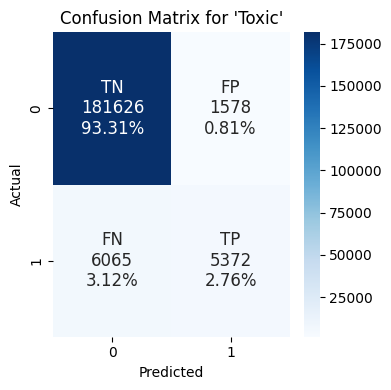

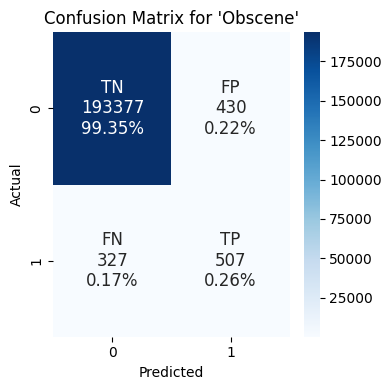

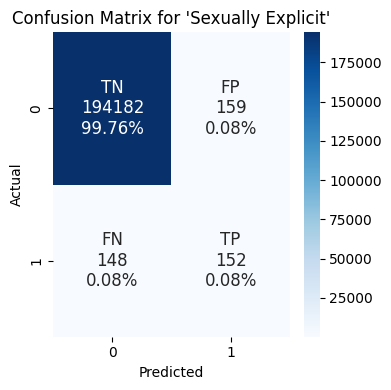

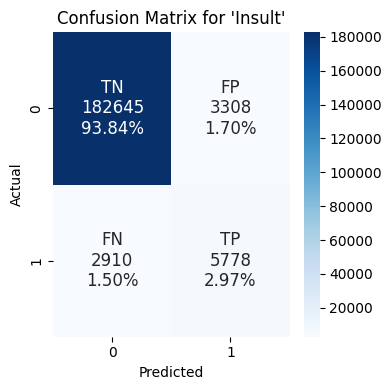

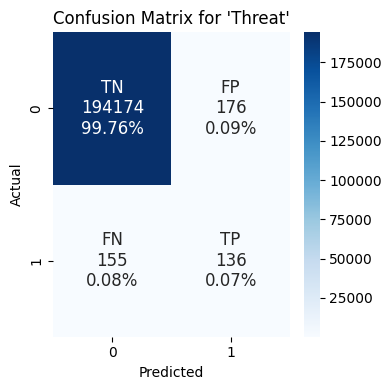

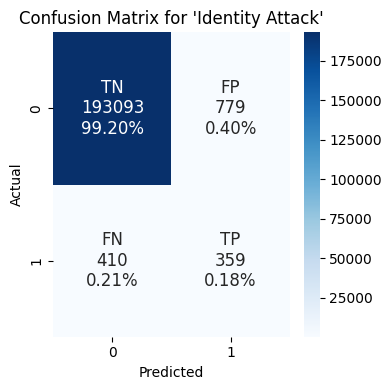

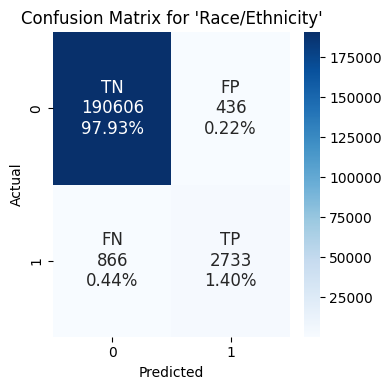

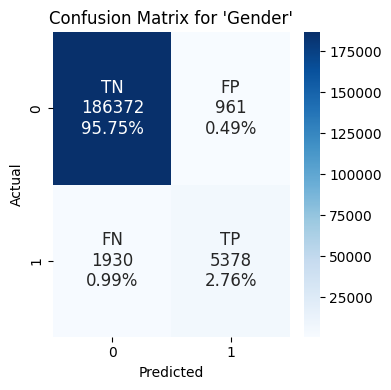

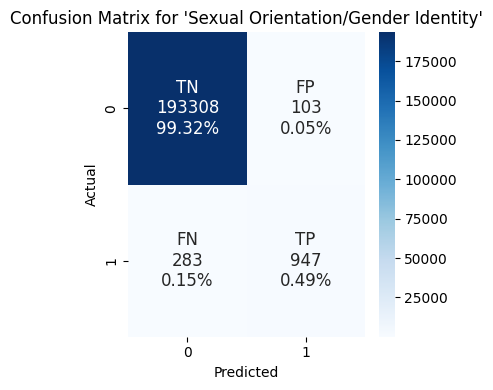

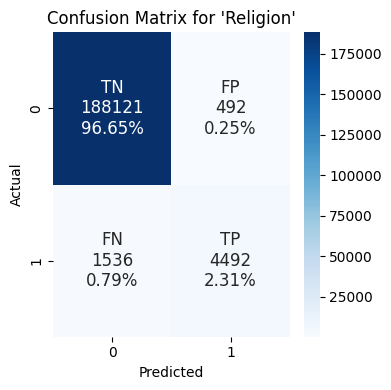

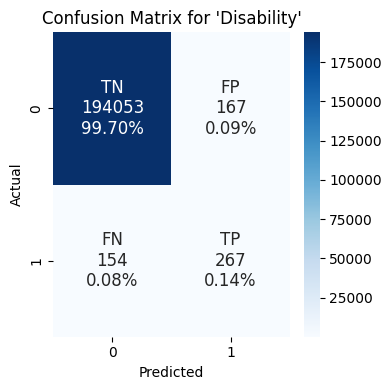

In [21]:
def plot_confusion_matrices(true_labels, predictions, figsize=(5, 5)):
    # Loop over each label and create a confusion matrix
    for i in range(11):
        # Compute confusion matrix for label i
        cnf = confusion_matrix(true_labels[:, i], predictions[:, i])
        group_names = ['TN','FP','FN','TP']
        group_counts = ['{0:0.0f}'.format(value) for value in cnf.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in cnf.flatten()/np.sum(cnf)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        # Create a new figure with the specified size
        plt.figure(figsize=figsize)

        # Plot confusion matrix as a heatmap
        sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues', annot_kws={'size':12})
        plt.title(f"Confusion Matrix for '{prediction_labels[i]}'")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()

        # Show the plot
        plt.show()

# Call the function to plot confusion matrices for all 12 labels
plot_confusion_matrices(true_labels, binary_predictions_f1, figsize=(4, 4))

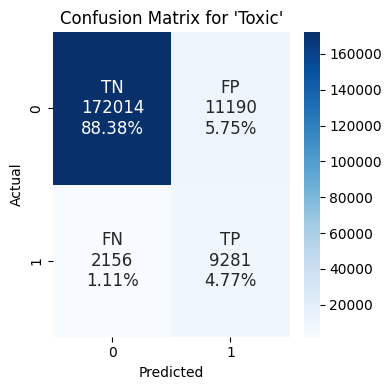

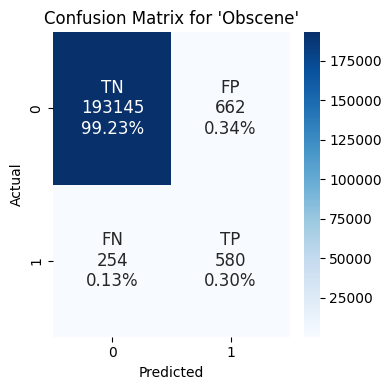

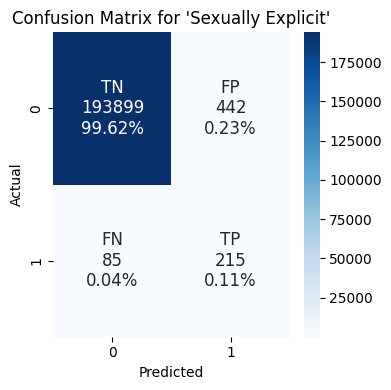

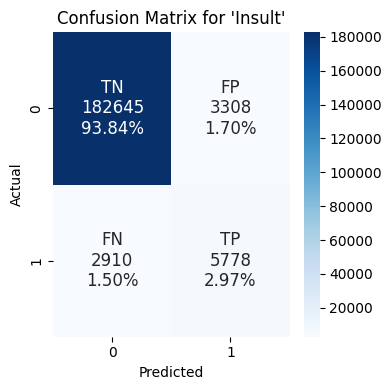

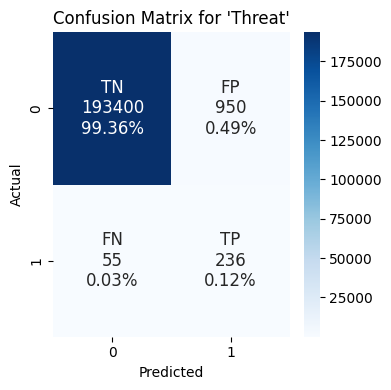

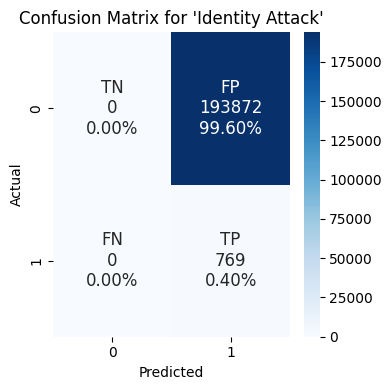

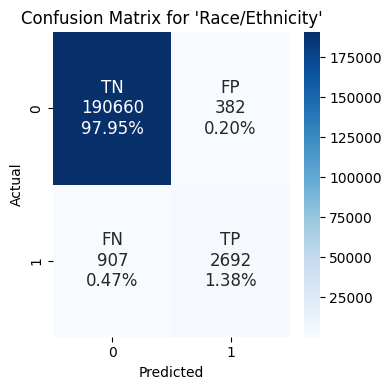

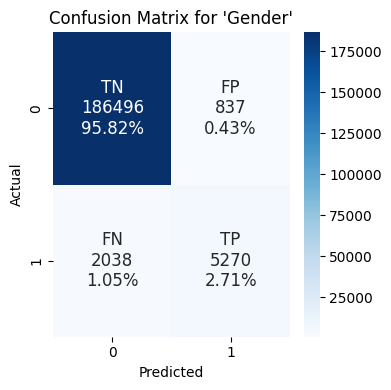

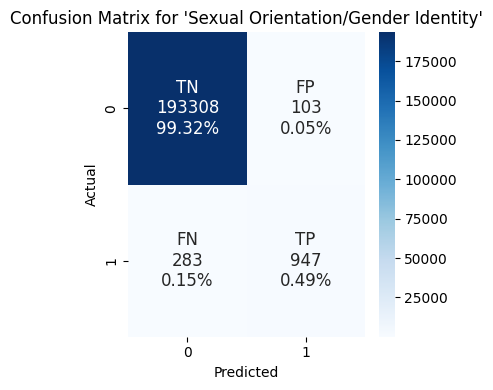

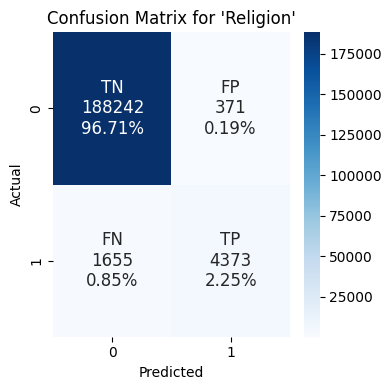

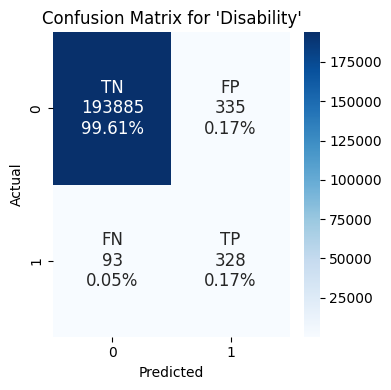

In [22]:
# Call the function to plot confusion matrices for all 12 labels
plot_confusion_matrices(true_labels, binary_predictions_pr_auc, figsize=(4, 4))

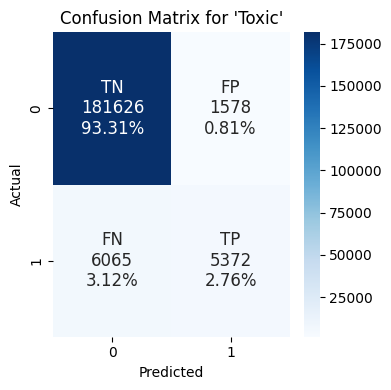

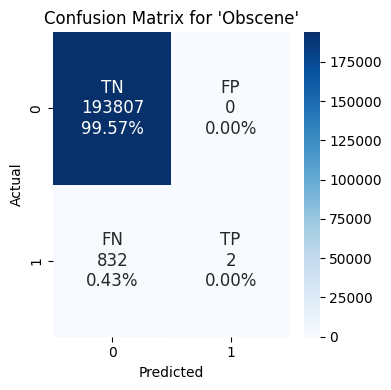

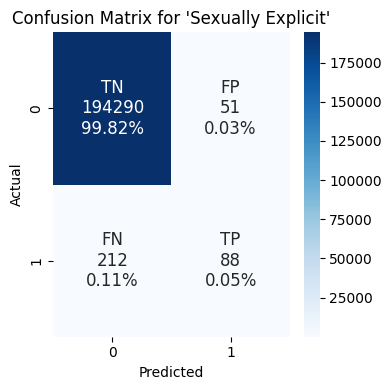

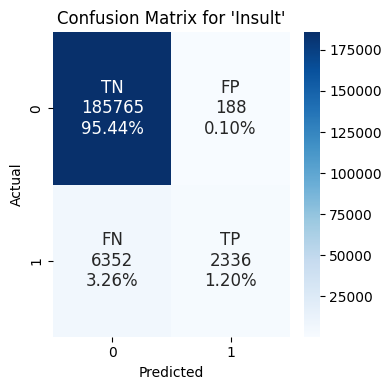

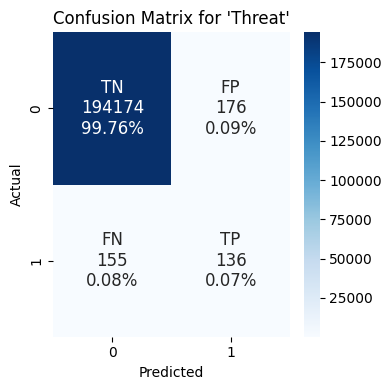

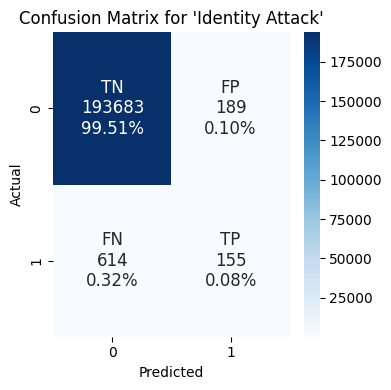

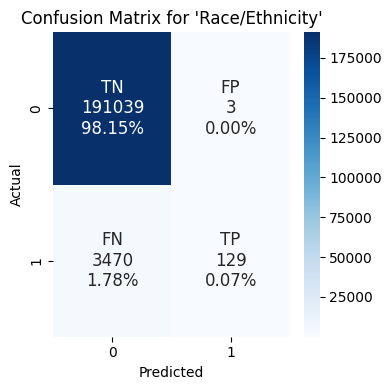

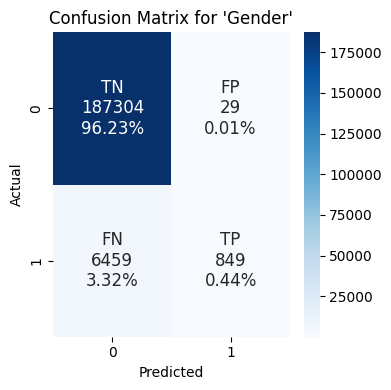

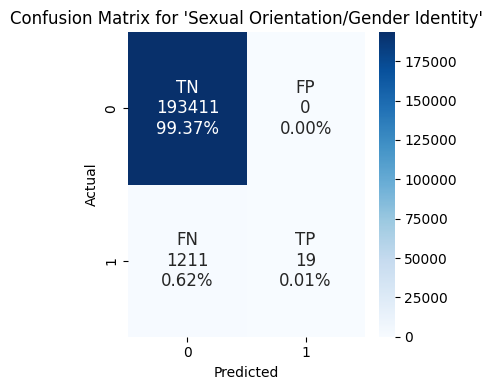

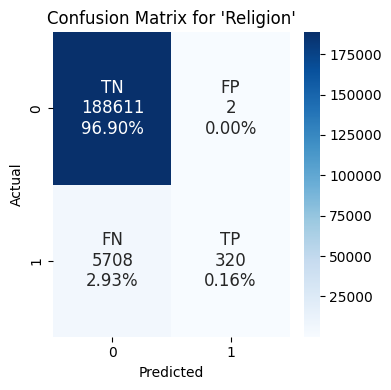

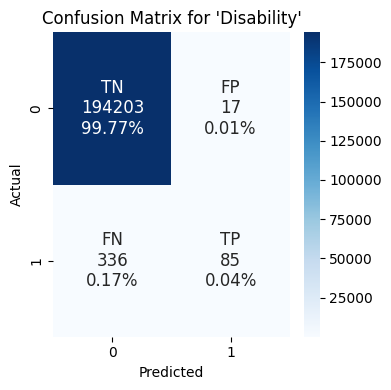

In [23]:
plot_confusion_matrices(true_labels, binary_predictions_precision, figsize=(4, 4))